![](https://i.imgur.com/eBRPvWB.png)

# 使用seq2seq网络和注意力机制实现汉-英翻译

这个项目，我们会实现一个汉语到英语的神经网络翻译模型。


这里实现的是论文[seq2seq 网络](http://arxiv.org/abs/1409.3215)的系统，它通过两个RNN来实现把一个训练翻译成两位一个序列。Encoder把输入序列编码成一个向量，而Decoder会把这个向量解码成两位一个输出序列。

为了提升效果，我们使用了[注意力机制](https://arxiv.org/abs/1409.0473)，它可以让decoder学习到在翻译的过程中怎么重点关注输入序列的某一部分。

## sequence to sequence模型

sequence to sequence模型，或者说seq2seq模型，由两个RNN组成。这两个RNN分别叫做encoder和decoder。
encoder会一个词一个出的读入输入序列，每一步都有一个输出，而最后的输出叫做context向量，我们可以认为是模型对源语言句子“语义”的一种表示。而decoder用这个context向量一步一步的生成目标语言的句子。

![](seq2seq.png)

为什么要两个RNN呢，如果我们使用一个RNN，输入和输出是一对一的关系（对于分类，我们可以只使用最后一个输出），但是翻译肯定不是一个词对一个词的翻译。当然这只是使用两个RNN在形式上的方便，从“原理”上来说，人类翻译也是类似的，首先仔细阅读源语句，然后“理解”它，而所谓的“理解”在seq2seq模型里可以认为encoding的过程，然后再根据理解，翻译成目标语句。

## 注意力机制

用一个固定长度的向量来承载输入序列的完整“语义”，不管向量能有多长，都是很困难的事情。

[Bahdanau et al.等人引入的](https://arxiv.org/abs/1409.0473) **注意力机制**试图这样来解决这个问题：我们不依赖于一个固定长度的向量，而是通过“注意”输入的某些部分。在decoer每一步解码的时候都通过这个机制来选择输入的一部分来重点考虑。这似乎是合乎人类的翻译过程的——我们首先通过一个encoder大致理解句子的意思（编码到一个定长向量），具体翻译某个词或者短语的时候我们会仔细推敲对应的源语言的词（注意力机制）。

![](https://i.imgur.com/5y6SCvU.png)

注意力是通过decoder的另外一个神经网络层来计算的。它的输入是当前输入和上一个时刻的隐状态，输出是一个新的向量，这个向量的长度和输入相同（因为输入是变长的，我们会选择一个最大的长度），这个向量会用softmax变成“概率”，得到*注意力权重*，这个权重可以认为需要花费多大的“注意力”到某个输入上，因此我们会用这个权重加权平均encoder的输出，从而得到一个新的context向量，这个向量会用来预测当前时刻的输出。

![](https://i.imgur.com/K1qMPxs.png)

## 依赖

我们需要[PyTorch](http://pytorch.org/)来构建和训练模型，需要[matplotlib](https://matplotlib.org/) 来绘图，剩下的都是Python自带的库。

In [1]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from masked_cross_entropy import *

import matplotlib.pyplot as plt
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

如果没有GPU，请设置为False，但是训练时间可能会比较长。

In [2]:
USE_CUDA = True

## 加载数据

训练数据是几千个英语到汉语的平行句对。我们这里只是介绍算法，所以使用一个很小的数据集来演示。数据在data/eng-chn.txt里，格式如下：
```
I won!  我 赢 了 。
```

每一行都是一个句对，用tab分割，中文部分已经提前分完词了(空格分开，所以split就可以得到中文的词)。

我们会用one-hot的方法来表示一个单词。

### 单词变成数字

我们会创建一个Lang对象来表示源/目标语言，它包含word2idx、idx2word和word2count，分别表示单词到id、id到单词和单词的词频。
word2count的作用是用于过滤一些低频词（把它变成unknown）

In [3]:
#按字分词，目前不需要了。
def seg_cn_words(s):
    words=[]
    for ch in s:
        if ch !=' ':
            words.append(ch)
    return words

In [4]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

    def seg_words(self, sentence):
#        if self.name=='chn':
#            return seg_cn_words(sentence)
        return sentence.split(' ')
        
    def index_words(self, sentence):
        words=self.seg_words(sentence)
        for word in words:
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # 删除掉频率少于阈值的此。
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # 重新构建dict
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # 默认3个词。

        for word in keep_words:
            self.index_word(word)

### 读取和预处理 

我们会只保留文本里的英文和中文字符，把大小转换成小写。

In [5]:

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 大写转小写，trim，移除常见标点，英文和中文之外的字符。
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z\u4e00-\u9fa5,.!?，。！？]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [6]:
s=unicode_to_ascii("中文word  cn!")
print(s)
s=normalize_string(s)
print(s)

中文word  cn!
中文word cn !


文件格式是每行一个句对，用tab分隔，第一个是英语，第二个是汉语，为了方便未来的复用，我们有一个reverse参数，这样如果我们需要汉语到英语的翻译就可以用到。如果读者想实现英语到汉英的翻译系统，那么只需要reverse为False就行。

In [7]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读取文件
    filename = '../data/%s-%s.txt' % (lang1, lang2)
    lines = open(filename).read().strip().split('\n')

    # Split
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    # 反转句对，从英汉变成汉英
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
MIN_LENGTH = 3
MAX_LENGTH = 25

def filter_pairs(pairs):
    filtered_pairs = []
    for pair in pairs:
        if len(pair[0]) >= MIN_LENGTH and len(pair[0]) <= MAX_LENGTH \
            and len(pair[1]) >= MIN_LENGTH and len(pair[1]) <= MAX_LENGTH:
                filtered_pairs.append(pair)
    return filtered_pairs

数据处理过程如下：

* 读取文件，split成行，再split成pair
* 文本归一化，过滤掉过短(小于3)和过长(大于25)的句对。
* 通过pair里的句子得到单词列表


In [9]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %d sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Filtered to %d pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])
    
    print('Indexed %d words in input language, %d words in output' % (input_lang.n_words, output_lang.n_words))
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('eng', 'chn', True)

Reading lines...
Read 19777 sentence pairs
Filtered to 5095 pairs
Indexing words...
Indexed 2930 words in input language, 2258 words in output


### 过滤词汇 

我们会取得词频低于5的词语。对于低频的词和词典之外的词(OOV)，系统很难学习，这是学术研究的一个难点，我们暂时忽略掉这些低频词。

In [10]:
MIN_COUNT = 5

input_lang.trim(MIN_COUNT)
output_lang.trim(MIN_COUNT)

keep_words 578 / 2927 = 0.1975
keep_words 568 / 2255 = 0.2519


In [11]:
print(input_lang.name)

chn


### 过滤句对

我们接下来去掉包含低频词或者OOV的句对。

In [12]:
keep_pairs = []

for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    words=input_lang.seg_words(input_sentence)
    for word in words:
        if word not in input_lang.word2index:
            keep_input = False
            break
            
    words=output_lang.seg_words(output_sentence)
    for word in words:
        if word not in output_lang.word2index:
            keep_output = False
            break

    # Remove if pair doesn't match input and output conditions
    if keep_input and keep_output:
        keep_pairs.append(pair)

print("Trimmed from %d pairs to %d, %.4f of total" % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs = keep_pairs


Trimmed from 5095 pairs to 1854, 0.3639 of total


In [13]:
print(pairs[2])

['我 赢 了 。', 'i won !']


## 把训练数据变成Tensor/Variable

为了让神经网络能够处理，我们首先需要把句子变成Tensor。每个句子首先分成词，每个词被替换成对应的index。另外我们会增加一个特殊的EOS来表示句子的结束。

![](https://i.imgur.com/LzocpGH.png)

在PyTorch里一个Tensor是一个多维数组，它的所有元素的数据类型都是一样的。我们这里使用LongTensor来表示词的index。

可以训练的PyTorch模块要求输入是Variable而不是Tensor。变量除了包含Tensor的内容之外，它还会跟踪计算图的状态，从而可以进行自动梯度的求值。

In [14]:
# 把句子变成index的list，最后加上EOS
def indexes_from_sentence(lang, sentence):
    idxs=[]
    words=lang.seg_words(sentence)
    for word in words:
        if word in lang.word2index:
            idxs.append(lang.word2index[word])
    idxs.append(EOS_token)
    return idxs

为了更好的使用GPU，我们一次训练一个batch的数据，但是问题是不同句对的长度是不一样的。解决办法是通过“pad”来把短的序列补到和长的序列一样长，我们需要一个特殊的整数来表示它是一个pad值而不是其他的词，我们这里使用0。当计算loss的时候，我们也需要把这些0对应的loss去掉（因为实际的序列到这里已经没有了，但是padding之后任何会计算出模型的预测值，从而有loss）


![](https://i.imgur.com/gGlkEEF.png)

In [15]:
# 把一个序列padding到长度为max_length。
def pad_seq(seq, max_length):
    seq += [PAD_token for i in range(max_length - len(seq))]
    return seq

训练一次需要一个batch的数据，我们一般随机的抽取bach_size个句对，然后把它们padding到最长的序列长度。此外，我们需要记录下未padding之前的长度，因为计算loss的时候会需要用到它。

我们会用list的list来初始化LongTensor，这个list的大小是batch_size，list的每个元素是一个序列(句子)。这样我们可以得到一个`(batch_size x max_len)`的Tensor，但是因为训练时我们需要逐个时刻的计算batch_size个数据，所以我们需要把它转置成`(max_len x batch_size)`。这样tensor[t]就表示t时刻的batch_size个词。


![](https://i.imgur.com/nBxTG3v.png)

In [16]:
def random_batch(batch_size):
    input_seqs = []
    target_seqs = []

    # 随机选择pairs
    for i in range(batch_size):
        pair = random.choice(pairs)
        input_seqs.append(indexes_from_sentence(input_lang, pair[0]))
        target_seqs.append(indexes_from_sentence(output_lang, pair[1]))

    # 把输入和输出序列zip起来，通过输入的长度降序排列，然后unzip
    seq_pairs = sorted(zip(input_seqs, target_seqs), key=lambda p: len(p[0]), reverse=True)
    input_seqs, target_seqs = zip(*seq_pairs)
    
    # 对输入和输出序列都进行padding。
    input_lengths = [len(s) for s in input_seqs]
    input_padded = [pad_seq(s, max(input_lengths)) for s in input_seqs]
    target_lengths = [len(s) for s in target_seqs]
    target_padded = [pad_seq(s, max(target_lengths)) for s in target_seqs]

    # padding之后的shape是(batch_size x max_len)，我们需要把它转置成(max_len x batch_size)
    input_var = Variable(torch.LongTensor(input_padded)).transpose(0, 1)
    target_var = Variable(torch.LongTensor(target_padded)).transpose(0, 1)
    
    if USE_CUDA:
        input_var = input_var.cuda()
        target_var = target_var.cuda()
        
    return input_var, input_lengths, target_var, target_lengths

我们可以测试一下，它会返回两个`(max_len x batch_size)` tensor，这是输入和输出序列，同时也会返回padding之前的实际长度。


In [17]:
random_batch(2)

(Variable containing:
   330   330
   471    75
   275   141
   244    20
   379    15
   432   127
   229   229
     2     2
 [torch.cuda.LongTensor of size 8x2 (GPU 0)], [8, 8], Variable containing:
   300   300
    41   527
    34   465
   210   542
   234   361
     2   234
     0     2
 [torch.cuda.LongTensor of size 7x2 (GPU 0)], [6, 7])

# 构建模型

## Encoder

<img src="images/encoder-network.png" style="float: right" />


encoder的输入是batch大小的词序列——大小是`(max_len x batch_size)``LongTensor`，每个词都会输出一个向量，所以最终的输出是大小为  `(max_len x batch_size x hidden_size)`的`FloatTensor`。

输入序列的词会被fed到一个[embedding层 `nn.Embedding`](http://pytorch.org/docs/nn.html#embedding)从而得到每个词的embedding，这样得到一个`(max_len x batch_size x embedding_size【这里embedding_size==hidden_size，但这不是必须相等的】)`的Tensor，这个Tensor会输入到[GRU层 `nn.GRU`](http://pytorch.org/docs/nn.html#gru)。最终GRU的输出是`seq_len x batch_size x hidden_size`。

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # 注意：和前面的实现不同，这里没有时刻t的for循环，而是一次输入GRU直接计算出来
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack
        hidden = self._cat_directions(hidden)
        return outputs, hidden
    
    def _cat_directions(self, hidden):
        """ If the encoder is bidirectional, do the following transformation.
            Ref: https://github.com/IBM/pytorch-seq2seq/blob/master/seq2seq/models/DecoderRNN.py#L176
            -----------------------------------------------------------
            In: (num_layers * num_directions, batch_size, hidden_size)
            (ex: num_layers=2, num_directions=2)

            layer 1: forward__hidden(1)
            layer 1: backward_hidden(1)
            layer 2: forward__hidden(2)
            layer 2: backward_hidden(2)

            -----------------------------------------------------------
            Out: (num_layers, batch_size, hidden_size * num_directions)

            layer 1: forward__hidden(1) backward_hidden(1)
            layer 2: forward__hidden(2) backward_hidden(2)
        """
        def _cat(h):
            return torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
            
        if isinstance(hidden, tuple):
            # LSTM hidden contains a tuple (hidden state, cell state)
            hidden = tuple([_cat(h) for h in hidden])
        else:
            # GRU hidden
            hidden = _cat(hidden)
            
        return hidden    

## Attention Decoder

### 理解Bahdanau等人提出的模型

下面我们来学习一下这篇文章提出的 [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) Attention Decoder。

decoder在每一个时刻的输出依赖与前一个时刻的输出和一个$\mathbf x$，这个$\mathbf x$包括当前的隐状态（它也会考虑前一个时刻的输出）和一个注意力”context“，下文会介绍它。函数$g$是一个带非线性激活的全连接层，它的输入是$y_{i-1}$, $s_i$ 和 $c_i$拼接起来的。

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

上式的意思是：我们在翻译当前词时只考虑上一个翻译出来的词以及当前的隐状态和注意力context。

当前隐状态$s_i$是有RNN $f$计算出来的，这个RNN的输入是上一个隐状态$s_{i-1}$，decoder的上一个输出$y_{i-1}$和 context向量$c_i$。

在代码实现中，我们使用的RNN是`nn.GRU`，隐状态 $s_i$是`hidden`，输出$y_i$是`output`， context $c_i$ 是`context`。

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

context向量$c_i$是encoder在每个时刻(词)的输出的加权和，而权值$a_{ij}$表示i时刻需要关注$h_j$的程度(概率)。

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

而权值$a_{ij}$是"能量" $e_{ij}$的softmax。

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

而能量$e_{ij}$是上个时刻的隐状态$s_{i-1}$和encoder第j个时刻的输出$h_j$的函数：

$$
e_{ij} = a(s_{i-1}, h_j)
$$

### Luong等人提出的模型

Luong等人在[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)提出了更多的提高和简化。他们描述了”全局注意力“模型，其计算注意力得分的方法和之前不同。前面是通过$s_{i-1}$和$h_j$计算$a_{ij}$，也就是当前的注意力权重依赖与前一个状态，而这里的注意力依赖与decoder当前的隐状态和encoder所有隐状态：

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

特点的"score"函数会比较两个隐状态的”相似度“，可以是两个向量的内积，也可以是$h_{s'}$做一个线性变换之后和$h_t$的内积，也可以是把两个向量拼接起来然后做一个线性变换，然后和一个参数$v_a$（这个参数是学习出来的）的内积：

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

scoring函数的模块化定义使得我们可以随意的修改而不影响其它地方的代码。这个模块的输入总是decoder的隐状态和encoder的所有输出。

### 计算注意力的通用模块

为了代码重用，这里把注意力的计算封装成一个模块，不管是哪个算法都可以复用它。

In [19]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size*2, hidden_size*2)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # 创建变量来存储注意力能量
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # 计算
        for b in range(this_batch_size):
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # softmax并且resize成1 x B x S
        return F.softmax(attn_energies).unsqueeze(1)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.v.dot(energy)
            return energy

现在我们可以构建一个decoder，它会把Attn模块放到RNN之后用来计算注意力的权重，并且用它来计算context向量。

In [20]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # 保存变量
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # 定义网络层
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size*2, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 4, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # 选择注意力计算方法
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # 注意：我们encoder一次计算所有时刻的数据，但是decoder我们目前还是一次计算一个时刻的（但是是一个batch）
        # 因为Teacher Forcing可以一次计算但是Random Sample必须逐个计算
        # 得到当前输入的embedding 
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # 计算gru的输出和新的隐状态，输入是当前词的embedding和之前的隐状态。
        rnn_output, hidden = self.gru(embedded, last_hidden)
        
        
        # 根据当前的RNN状态和encoder的输出计算注意力。
        # 根据注意力计算context向量 
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # 把gru的输出和context vector拼接起来
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # 预测下一个token，这里没有softmax，只有计算loss的时候才需要。
        output = self.out(concat_output)

        # 返回最终的输出，GRU的隐状态和attetion（用于可视化）
        return output, hidden, attn_weights

## 测试模型

为了初步验证上面的代码是否正确，我们用少量的数据来跑一下。

In [21]:
small_batch_size = 3
input_batches, input_lengths, target_batches, target_lengths = random_batch(small_batch_size)

print('input_batches', input_batches.size()) # (max_len x batch_size)
print('target_batches', target_batches.size()) # (max_len x batch_size)

input_batches torch.Size([8, 3])
target_batches torch.Size([8, 3])


创建一个较小的模型用来验证代码

In [22]:
small_hidden_size = 8
small_n_layers = 2

encoder_test = EncoderRNN(input_lang.n_words, small_hidden_size, small_n_layers)
decoder_test = LuongAttnDecoderRNN('general', small_hidden_size, output_lang.n_words, small_n_layers)

if USE_CUDA:
    encoder_test.cuda()
    decoder_test.cuda()

测试encoder

In [23]:
encoder_outputs, encoder_hidden = encoder_test(input_batches, input_lengths, None)

print('encoder_outputs', encoder_outputs.size()) # max_len x batch_size x hidden_size
print('encoder_hidden', encoder_hidden.size()) # n_layers * 2 x batch_size x hidden_size

encoder_outputs torch.Size([8, 3, 16])
encoder_hidden torch.Size([2, 3, 16])


然后我们从SOS开始，然后用decoder来逐个解码。和encoder不同，encoder是一次处理整个序列，但是decoder必须逐个解码，因为在预测（或者random sampling时）都必须把上一个时刻的输出作为当前时刻的输入。所以前一个时刻没有处理完是没有办法处理下一个时刻的数据的。不过我们仍然是一次处理一个batch的数据的，比如之前的效率还是会提高。


In [24]:
max_target_length = max(target_lengths)

# decoder的第一个输入是SOS
decoder_input = Variable(torch.LongTensor([SOS_token] * small_batch_size))
decoder_hidden = encoder_hidden # 把第一层的encoder的输出作为decoder的输入。
all_decoder_outputs = Variable(torch.zeros(max_target_length, small_batch_size, decoder_test.output_size))

if USE_CUDA:
    all_decoder_outputs = all_decoder_outputs.cuda()
    decoder_input = decoder_input.cuda()

# 遍历Run through decoder one time step at a time
for t in range(max_target_length):
    decoder_output, decoder_hidden, decoder_attn = decoder_test(
        decoder_input, decoder_hidden, encoder_outputs
    )
    all_decoder_outputs[t] = decoder_output # Store this step's outputs
    decoder_input = target_batches[t] # Next input is current target

# 通过mask计算交叉熵
loss = masked_cross_entropy(
    all_decoder_outputs.transpose(0, 1).contiguous(),
    target_batches.transpose(0, 1).contiguous(),
    target_lengths,
    USE_CUDA
)
print('loss', loss.data[0])

loss 6.295614719390869


/home/lili/tf1.5-py3/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



## 训练

### 一次训练

对于一个训练数据，我们首先用encoder对输入句子进行编码，得到每个时刻的输出和最后一个时刻的隐状态。最后一个隐状态会作为decoder隐状态的初始值，并且我们会用一个特殊的`<SOS>`作为decoder的第一个输入。


In [25]:
def train(input_batches, input_lengths, target_batches, target_lengths, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    # 梯度清空
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # 进行encoding
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)
    
    # 准备输入和输出变量
    decoder_input = Variable(torch.LongTensor([SOS_token] * batch_size))
    decoder_hidden = encoder_hidden
    #decoder_hidden = decoder_hidden.contiguous()
    
    max_target_length = max(target_lengths)
    all_decoder_outputs = Variable(torch.zeros(max_target_length, batch_size, decoder.output_size))


    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        all_decoder_outputs = all_decoder_outputs.cuda()

    # 解码
    for t in range(max_target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )

        all_decoder_outputs[t] = decoder_output
        decoder_input = target_batches[t] # 当前输出是下一个时刻的输入。

    # 计算loss和反向计算梯度
    loss = masked_cross_entropy(
        all_decoder_outputs.transpose(0, 1).contiguous(), # -> batch x seq
        target_batches.transpose(0, 1).contiguous(), # -> batch x seq
        target_lengths,
        USE_CUDA
    )
    loss.backward()
    
    # clip梯度
    ec = torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    dc = torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

    # 更新参数
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0], ec, dc

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, a loss function (criterion), and set up variables for plotting and tracking progress:

In [26]:
# 模型的配置
attn_model = 'dot'
hidden_size = 500
n_layers = 2
dropout = 0.1
batch_size = 100

# 训练的超参数
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_epochs = 50000
epoch = 0
plot_every = 20
print_every = 100
evaluate_every = 1000

# 初始化模型
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers, dropout=dropout)
decoder = LuongAttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout=dropout)

# 初始化optimizers和criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

# 把模型放到GPU上
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# 计时
start = time.time()
plot_losses = []
print_loss_total = 0 # 每过print_every次清零
plot_loss_total = 0 # 没过plot_every次清零

一些工具函数

In [27]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## 预测(翻译)


In [28]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_lengths=[len(sen) for sen in input_seqs]
    input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    
    if USE_CUDA:
        input_batches = input_batches.cuda()
        
    # 预测的时候不需要更新参数
    encoder.train(False)
    decoder.train(False)
    
    # encoding
    encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # 创建开始的SOS
    decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_hidden = encoder_hidden
    #decoder_hidden = decoder_hidden.contiguous()
    
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [29]:
def evaluate_randomly():
    [input_sentence, target_sentence] = random.choice(pairs)
    evaluate_and_show_attention(input_sentence, target_sentence)

# 注意力的可视化

注意力机制的一个优点是它的输出的可解释性。因为它在decode每一步都会对所以输入赋予不同的权重，因此我们可以认为它在翻译这个词的时候”对应“了源语言的词的权重，这可以认为是一种对齐。

In [30]:
import io
import torchvision
from PIL import Image
import visdom
vis = visdom.Visdom()

def show_plot_visdom():
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    attn_win = 'attention (%s)' % hostname
    vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

为了更好的可视化效果，我们下面设置colorbar和axes

In [31]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    words=input_lang.seg_words(input_sentence)
    ax.set_xticklabels([''] + words + ['<EOS>'])
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    show_plot_visdom()
    plt.show()
    plt.close()

In [32]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
    win = 'evaluted (%s)' % hostname
    text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
    vis.text(text, win=win, opts={'title': win})

# 放到一起

接下来就是开始训练了，注意需要在先运行 python -m visdom.server

/home/lili/tf1.5-py3/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


3m 0s (- 1504m 0s) (100 0%) 3.2140
6m 7s (- 1523m 37s) (200 0%) 1.6993
9m 11s (- 1523m 3s) (300 0%) 0.8486
12m 11s (- 1512m 32s) (400 0%) 0.3999
15m 12s (- 1505m 39s) (500 1%) 0.2001
18m 18s (- 1507m 50s) (600 1%) 0.1170
21m 22s (- 1505m 25s) (700 1%) 0.0748
24m 24s (- 1500m 47s) (800 1%) 0.0559
27m 26s (- 1497m 19s) (900 1%) 0.0497
30m 31s (- 1495m 49s) (1000 2%) 0.0408
> 我们 正在 吃 苹果 。
= we re eating apples .
< we re eating apples . <EOS>


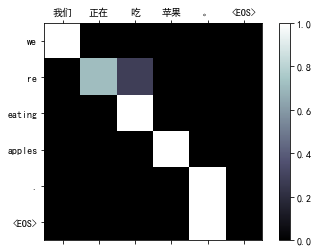

33m 39s (- 1496m 16s) (1100 2%) 0.0357
36m 43s (- 1493m 23s) (1200 2%) 0.0353
39m 48s (- 1491m 11s) (1300 2%) 0.0340
42m 54s (- 1489m 19s) (1400 2%) 0.0509
46m 2s (- 1488m 34s) (1500 3%) 0.0526
49m 6s (- 1485m 32s) (1600 3%) 0.0434
52m 10s (- 1482m 28s) (1700 3%) 0.0306
55m 13s (- 1478m 55s) (1800 3%) 0.0280
58m 20s (- 1476m 45s) (1900 3%) 0.0264
61m 25s (- 1474m 21s) (2000 4%) 0.0260
> 他们 没 看见 我们 。
= they didn t see us .
< they didn t see us . <EOS>


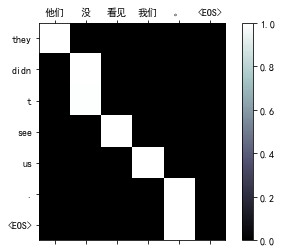

64m 29s (- 1471m 2s) (2100 4%) 0.0245
67m 34s (- 1468m 6s) (2200 4%) 0.0244
70m 36s (- 1464m 22s) (2300 4%) 0.0242
73m 40s (- 1461m 7s) (2400 4%) 0.0231
76m 43s (- 1457m 53s) (2500 5%) 0.0249
79m 44s (- 1453m 52s) (2600 5%) 0.0253
82m 47s (- 1450m 19s) (2700 5%) 0.0229
85m 49s (- 1446m 48s) (2800 5%) 0.0246
88m 58s (- 1444m 58s) (2900 5%) 0.0236
92m 3s (- 1442m 14s) (3000 6%) 0.0214
> 给 我 这 本 书 。
= give me the book .
< give me the book . <EOS>


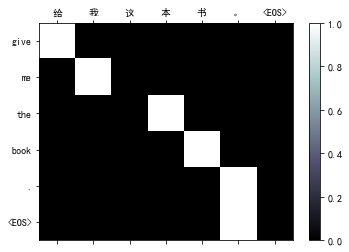

95m 6s (- 1438m 51s) (3100 6%) 0.0229
98m 8s (- 1435m 17s) (3200 6%) 0.0213
101m 10s (- 1431m 53s) (3300 6%) 0.0221
104m 16s (- 1429m 9s) (3400 6%) 0.0551
107m 19s (- 1425m 58s) (3500 7%) 0.0513
110m 24s (- 1423m 7s) (3600 7%) 0.0313
113m 28s (- 1420m 0s) (3700 7%) 0.0305
116m 33s (- 1417m 2s) (3800 7%) 0.0267
119m 33s (- 1413m 18s) (3900 7%) 0.0237
122m 37s (- 1410m 15s) (4000 8%) 0.0235
> 那 是 一个 好 主意 。
= that s a good idea .
< that s a good idea . <EOS>


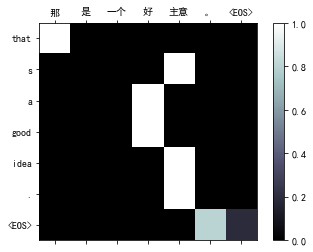

125m 41s (- 1407m 13s) (4100 8%) 0.0225
128m 42s (- 1403m 30s) (4200 8%) 0.0220
131m 47s (- 1400m 43s) (4300 8%) 0.0226
134m 49s (- 1397m 14s) (4400 8%) 0.0216
137m 52s (- 1394m 7s) (4500 9%) 0.0210
140m 57s (- 1391m 9s) (4600 9%) 0.0212
144m 1s (- 1388m 10s) (4700 9%) 0.0219
147m 7s (- 1385m 22s) (4800 9%) 0.0219
150m 10s (- 1382m 15s) (4900 9%) 0.0230
153m 16s (- 1379m 24s) (5000 10%) 0.0224
> 我 想 他 会 来 的 吧 。
= i think he ll come .
< i think he ll come . <EOS>


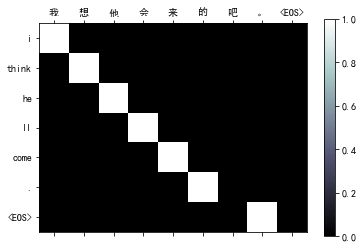

156m 21s (- 1376m 34s) (5100 10%) 0.0209
159m 28s (- 1373m 53s) (5200 10%) 0.0206
162m 30s (- 1370m 34s) (5300 10%) 0.0211
165m 33s (- 1367m 27s) (5400 10%) 0.0205
168m 38s (- 1364m 31s) (5500 11%) 0.0219
171m 41s (- 1361m 16s) (5600 11%) 0.0210
174m 47s (- 1358m 28s) (5700 11%) 0.0206
177m 53s (- 1355m 37s) (5800 11%) 0.0213
180m 59s (- 1352m 51s) (5900 11%) 0.0213
184m 3s (- 1349m 47s) (6000 12%) 0.0286
> 我 应该 去 做 。
= i should do it .
< i should do it . <EOS>


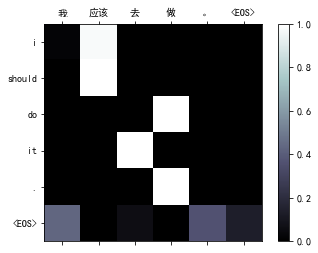

187m 9s (- 1346m 54s) (6100 12%) 0.0559
190m 10s (- 1343m 29s) (6200 12%) 0.0343
193m 15s (- 1340m 32s) (6300 12%) 0.0251
196m 18s (- 1337m 23s) (6400 12%) 0.0221
199m 25s (- 1334m 35s) (6500 13%) 0.0231
202m 30s (- 1331m 38s) (6600 13%) 0.0214
205m 33s (- 1328m 27s) (6700 13%) 0.0214
208m 37s (- 1325m 23s) (6800 13%) 0.0230
211m 43s (- 1322m 33s) (6900 13%) 0.0249
214m 44s (- 1319m 8s) (7000 14%) 0.0257
> 这 是 谁 的 书 ?
= whose book is this ?
< whose book is this ? <EOS>


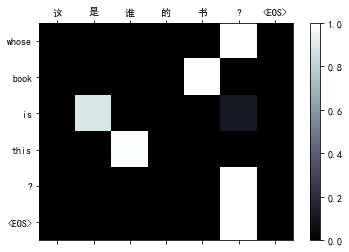

217m 50s (- 1316m 12s) (7100 14%) 0.0224
220m 54s (- 1313m 8s) (7200 14%) 0.0236
223m 57s (- 1309m 59s) (7300 14%) 0.0226
227m 4s (- 1307m 12s) (7400 14%) 0.0215
230m 7s (- 1304m 4s) (7500 15%) 0.0211
233m 13s (- 1301m 8s) (7600 15%) 0.0214
236m 19s (- 1298m 15s) (7700 15%) 0.0201
239m 23s (- 1295m 11s) (7800 15%) 0.0211
242m 30s (- 1292m 21s) (7900 15%) 0.0220
245m 36s (- 1289m 27s) (8000 16%) 0.0213
> 你 不是 汤姆 吗 ?
= aren t you tom ?
< aren t you tom ? <EOS>


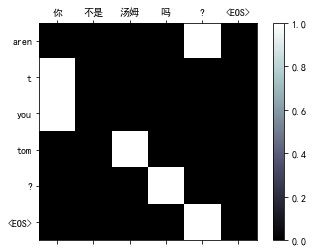

248m 41s (- 1286m 26s) (8100 16%) 0.0206
251m 42s (- 1283m 4s) (8200 16%) 0.0212
254m 46s (- 1279m 59s) (8300 16%) 0.0208
257m 52s (- 1277m 8s) (8400 16%) 0.0203
260m 56s (- 1274m 1s) (8500 17%) 0.0206
264m 4s (- 1271m 12s) (8600 17%) 0.0212
267m 6s (- 1267m 58s) (8700 17%) 0.0217
270m 16s (- 1265m 21s) (8800 17%) 0.0209
273m 25s (- 1262m 38s) (8900 17%) 0.0214
276m 33s (- 1259m 53s) (9000 18%) 0.0217
> 你 认识 他 吗 ?
= do you know him ?
< do you know him ? <EOS>


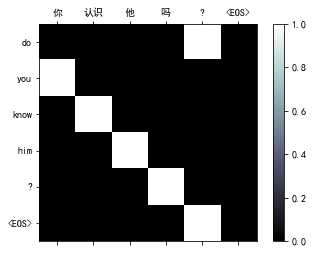

279m 40s (- 1257m 0s) (9100 18%) 0.0210
282m 50s (- 1254m 20s) (9200 18%) 0.0211
296m 35s (- 1298m 0s) (9300 18%) 0.0199
311m 47s (- 1346m 40s) (9400 18%) 0.0202
326m 48s (- 1393m 13s) (9500 19%) 0.0203
342m 43s (- 1442m 19s) (9600 19%) 0.0205
357m 31s (- 1485m 21s) (9700 19%) 0.0201
371m 42s (- 1524m 46s) (9800 19%) 0.0202
386m 54s (- 1567m 9s) (9900 19%) 0.0224
401m 29s (- 1605m 57s) (10000 20%) 0.0417
> 让 我们 开始 这个 派对 吧 。
= let s start the party .
< let s start the party . <EOS>


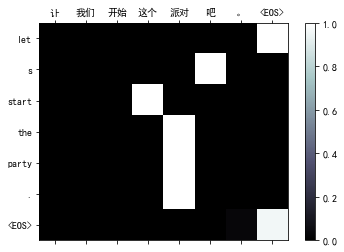

417m 7s (- 1647m 52s) (10100 20%) 0.0472
431m 16s (- 1682m 48s) (10200 20%) 0.0335
446m 52s (- 1722m 26s) (10300 20%) 0.0237
451m 24s (- 1718m 49s) (10400 20%) 0.0223
455m 59s (- 1715m 23s) (10500 21%) 0.0213
460m 40s (- 1712m 18s) (10600 21%) 0.0220
465m 21s (- 1709m 13s) (10700 21%) 0.0210
469m 54s (- 1705m 36s) (10800 21%) 0.0216
474m 24s (- 1701m 46s) (10900 21%) 0.0205
479m 3s (- 1698m 28s) (11000 22%) 0.0202
> 我 可以 出去 玩 吗 ?
= may i go out to play ?
< may i go out to play ? <EOS>


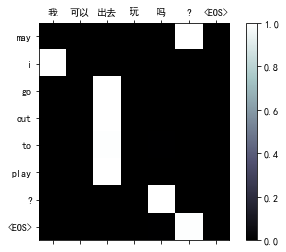

483m 39s (- 1694m 58s) (11100 22%) 0.0209
488m 11s (- 1691m 14s) (11200 22%) 0.0213
492m 48s (- 1687m 44s) (11300 22%) 0.0211
497m 22s (- 1684m 5s) (11400 22%) 0.0212
502m 0s (- 1680m 37s) (11500 23%) 0.0204
506m 35s (- 1676m 58s) (11600 23%) 0.0210
511m 10s (- 1673m 19s) (11700 23%) 0.0211
515m 49s (- 1669m 53s) (11800 23%) 0.0218
520m 26s (- 1666m 18s) (11900 23%) 0.0208
524m 56s (- 1662m 18s) (12000 24%) 0.0205
> 让 我 看看 。
= let me have a look .
< let me see it . <EOS>


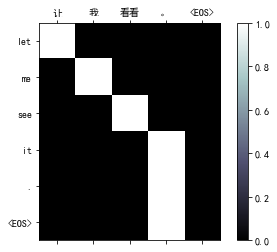

529m 28s (- 1658m 27s) (12100 24%) 0.0211
534m 4s (- 1654m 45s) (12200 24%) 0.0210
538m 39s (- 1651m 1s) (12300 24%) 0.0210
543m 17s (- 1647m 23s) (12400 24%) 0.0216
547m 57s (- 1643m 51s) (12500 25%) 0.0205
552m 33s (- 1640m 7s) (12600 25%) 0.0207
557m 8s (- 1636m 18s) (12700 25%) 0.0203
561m 42s (- 1632m 28s) (12800 25%) 0.0210
566m 15s (- 1628m 32s) (12900 25%) 0.0215
569m 17s (- 1620m 18s) (13000 26%) 0.0211
> 他 没 听 。
= he doesn t listen .
< he doesn t listen . <EOS>


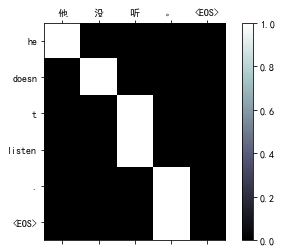

572m 24s (- 1612m 21s) (13100 26%) 0.0221
575m 29s (- 1604m 25s) (13200 26%) 0.0217
578m 33s (- 1596m 28s) (13300 26%) 0.0322
581m 36s (- 1588m 33s) (13400 26%) 0.0320
584m 37s (- 1580m 39s) (13500 27%) 0.0271
587m 45s (- 1573m 6s) (13600 27%) 0.0234
590m 47s (- 1565m 23s) (13700 27%) 0.0224
593m 52s (- 1557m 52s) (13800 27%) 0.0215
596m 54s (- 1550m 14s) (13900 27%) 0.0217
600m 0s (- 1542m 53s) (14000 28%) 0.0221
> 他 像 他 父亲 。
= he is like his father .
< he is like his father . <EOS>


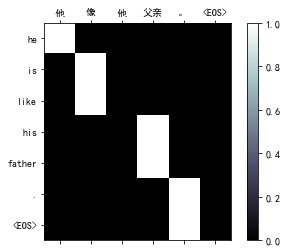

603m 2s (- 1535m 23s) (14100 28%) 0.0218
606m 5s (- 1528m 2s) (14200 28%) 0.0217
609m 10s (- 1520m 47s) (14300 28%) 0.0205
612m 17s (- 1513m 42s) (14400 28%) 0.0241
615m 23s (- 1506m 37s) (14500 28%) 0.0222
618m 26s (- 1499m 30s) (14600 29%) 0.0241
621m 30s (- 1492m 27s) (14700 29%) 0.0240
624m 35s (- 1485m 30s) (14800 29%) 0.0226
627m 36s (- 1478m 28s) (14900 29%) 0.0213
630m 41s (- 1471m 36s) (15000 30%) 0.0222
> 我们 需要 汤姆 回来 。
= we need tom back .
< we need tom back . <EOS>


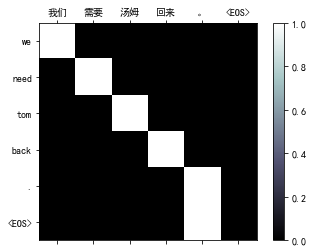

633m 47s (- 1464m 50s) (15100 30%) 0.0208
636m 51s (- 1458m 3s) (15200 30%) 0.0208
639m 53s (- 1451m 15s) (15300 30%) 0.0207
642m 52s (- 1444m 22s) (15400 30%) 0.0207
645m 57s (- 1437m 45s) (15500 31%) 0.0201
649m 0s (- 1431m 8s) (15600 31%) 0.0211
652m 7s (- 1424m 41s) (15700 31%) 0.0203
655m 13s (- 1418m 15s) (15800 31%) 0.0208
658m 15s (- 1411m 45s) (15900 31%) 0.0220
661m 20s (- 1405m 21s) (16000 32%) 0.0327
> 她 打 了 他 。
= she hit him .
< she hit him . <EOS>


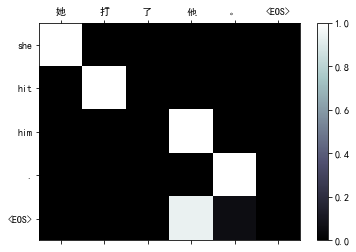

664m 25s (- 1398m 59s) (16100 32%) 0.0278
667m 29s (- 1392m 40s) (16200 32%) 0.0240
670m 32s (- 1386m 19s) (16300 32%) 0.0217
673m 37s (- 1380m 6s) (16400 32%) 0.0216
676m 41s (- 1373m 53s) (16500 33%) 0.0209
679m 45s (- 1367m 43s) (16600 33%) 0.0224
682m 49s (- 1361m 33s) (16700 33%) 0.0214
685m 54s (- 1355m 29s) (16800 33%) 0.0207
688m 58s (- 1349m 24s) (16900 33%) 0.0209
692m 5s (- 1343m 28s) (17000 34%) 0.0207
> 我 真 不 了解 汤姆 。
= i really don t know tom .
< i really don t know tom . <EOS>


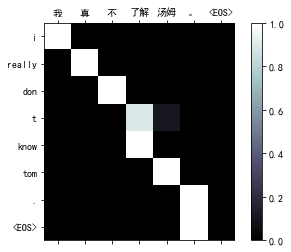

695m 9s (- 1337m 28s) (17100 34%) 0.0207
698m 11s (- 1331m 25s) (17200 34%) 0.0202
701m 16s (- 1325m 32s) (17300 34%) 0.0205
704m 17s (- 1319m 32s) (17400 34%) 0.0211
707m 20s (- 1313m 37s) (17500 35%) 0.0213
710m 27s (- 1307m 53s) (17600 35%) 0.0210
713m 32s (- 1302m 6s) (17700 35%) 0.0204
716m 37s (- 1296m 22s) (17800 35%) 0.0203
719m 43s (- 1290m 41s) (17900 35%) 0.0224
722m 50s (- 1285m 2s) (18000 36%) 0.0210
> 你 的 狗 在 哪里 ?
= where s your dog ?
< where is your dog ? <EOS>


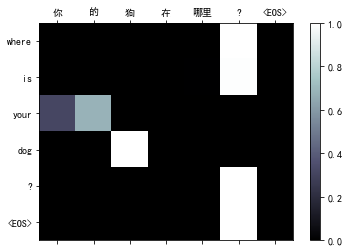

725m 55s (- 1279m 23s) (18100 36%) 0.0203
729m 0s (- 1273m 46s) (18200 36%) 0.0208
731m 59s (- 1267m 58s) (18300 36%) 0.0196
735m 5s (- 1262m 26s) (18400 36%) 0.0209
738m 9s (- 1256m 51s) (18500 37%) 0.0213
741m 13s (- 1251m 18s) (18600 37%) 0.0207
744m 20s (- 1245m 51s) (18700 37%) 0.0215
747m 25s (- 1240m 24s) (18800 37%) 0.0249
750m 29s (- 1234m 56s) (18900 37%) 0.0339
753m 32s (- 1229m 28s) (19000 38%) 0.0275
> 请 坐 。
= please take your seat .
< please take your seat . <EOS>


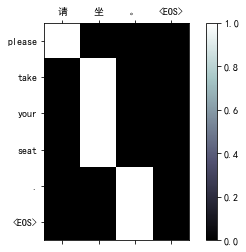

756m 35s (- 1224m 0s) (19100 38%) 0.0241
759m 41s (- 1218m 40s) (19200 38%) 0.0215
762m 43s (- 1213m 15s) (19300 38%) 0.0210
765m 45s (- 1207m 50s) (19400 38%) 0.0222
768m 50s (- 1202m 33s) (19500 39%) 0.0210
771m 56s (- 1197m 17s) (19600 39%) 0.0200
774m 58s (- 1191m 57s) (19700 39%) 0.0221
778m 2s (- 1186m 42s) (19800 39%) 0.0205
781m 6s (- 1181m 28s) (19900 39%) 0.0203
784m 9s (- 1176m 14s) (20000 40%) 0.0215
> 我会 游泳 。
= i can swim .
< i can swim . <EOS>


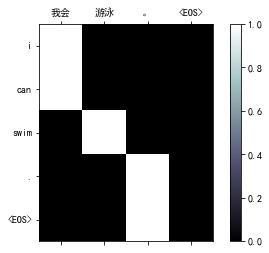

787m 11s (- 1170m 59s) (20100 40%) 0.0198
790m 13s (- 1165m 46s) (20200 40%) 0.0209
793m 16s (- 1160m 36s) (20300 40%) 0.0210
796m 24s (- 1155m 34s) (20400 40%) 0.0208
799m 29s (- 1150m 28s) (20500 41%) 0.0212
802m 32s (- 1145m 21s) (20600 41%) 0.0207
805m 35s (- 1140m 16s) (20700 41%) 0.0205
808m 40s (- 1135m 15s) (20800 41%) 0.0199
811m 48s (- 1130m 19s) (20900 41%) 0.0207
814m 54s (- 1125m 20s) (21000 42%) 0.0206
> 你 会 弹 钢琴 吗 ?
= can you play the piano ?
< can you play the piano ? <EOS>


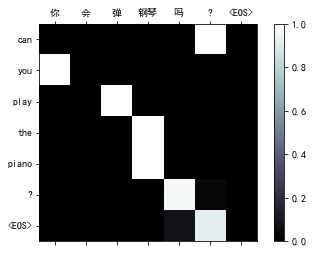

818m 2s (- 1120m 26s) (21100 42%) 0.0197
821m 7s (- 1115m 29s) (21200 42%) 0.0205
824m 11s (- 1110m 32s) (21300 42%) 0.0206
827m 16s (- 1105m 36s) (21400 42%) 0.0209
830m 21s (- 1100m 42s) (21500 43%) 0.0204
833m 27s (- 1095m 50s) (21600 43%) 0.0212
836m 30s (- 1090m 55s) (21700 43%) 0.0228
839m 35s (- 1086m 4s) (21800 43%) 0.0199
842m 39s (- 1081m 13s) (21900 43%) 0.0217
845m 43s (- 1076m 22s) (22000 44%) 0.0194
> 每个 人 都 高兴 。
= everyone was happy .
< everyone was happy . <EOS>


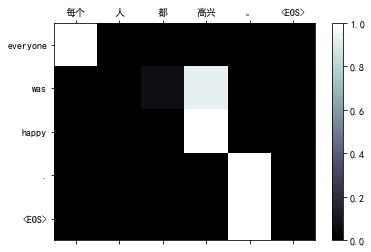

848m 50s (- 1071m 36s) (22100 44%) 0.0271
851m 52s (- 1066m 45s) (22200 44%) 0.0391
854m 53s (- 1061m 54s) (22300 44%) 0.0270
857m 59s (- 1057m 9s) (22400 44%) 0.0222
861m 4s (- 1052m 25s) (22500 45%) 0.0211
864m 13s (- 1047m 46s) (22600 45%) 0.0225
867m 18s (- 1043m 3s) (22700 45%) 0.0215
870m 26s (- 1038m 25s) (22800 45%) 0.0210
873m 33s (- 1033m 45s) (22900 45%) 0.0204
876m 32s (- 1028m 59s) (23000 46%) 0.0203
> 我 写 了 一封 信 。
= i wrote a letter .
< i wrote a letter . <EOS>


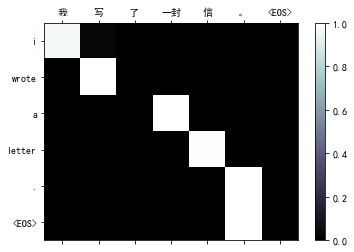

879m 35s (- 1024m 16s) (23100 46%) 0.0203
882m 37s (- 1019m 35s) (23200 46%) 0.0210
885m 41s (- 1014m 56s) (23300 46%) 0.0228
888m 46s (- 1010m 19s) (23400 46%) 0.0239
891m 50s (- 1005m 41s) (23500 47%) 0.0219
894m 54s (- 1001m 4s) (23600 47%) 0.0210
898m 1s (- 996m 32s) (23700 47%) 0.0211
901m 5s (- 991m 57s) (23800 47%) 0.0208
904m 9s (- 987m 23s) (23900 47%) 0.0201
907m 16s (- 982m 52s) (24000 48%) 0.0198
> 我 不 喜欢 你 。
= i don t like you .
< i don t like you . <EOS>


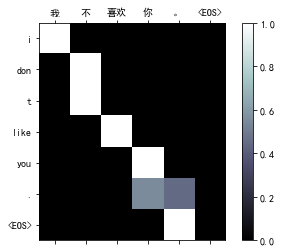

910m 23s (- 978m 22s) (24100 48%) 0.0205
913m 28s (- 973m 52s) (24200 48%) 0.0210
916m 34s (- 969m 22s) (24300 48%) 0.0209
919m 40s (- 964m 54s) (24400 48%) 0.0215
922m 41s (- 960m 20s) (24500 49%) 0.0204
925m 46s (- 955m 52s) (24600 49%) 0.0198
928m 49s (- 951m 22s) (24700 49%) 0.0209
931m 53s (- 946m 55s) (24800 49%) 0.0209
934m 54s (- 942m 24s) (24900 49%) 0.0199
938m 1s (- 938m 1s) (25000 50%) 0.0214
> 他 无法 得到 这 份 工作 。
= he couldn t get the job .
< he couldn t get the job . <EOS>


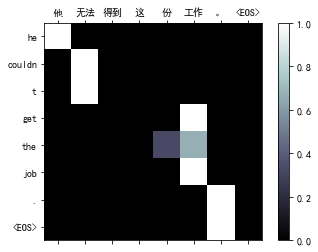

941m 8s (- 933m 38s) (25100 50%) 0.0210
944m 15s (- 929m 15s) (25200 50%) 0.0205
947m 20s (- 924m 52s) (25300 50%) 0.0201
950m 26s (- 920m 29s) (25400 50%) 0.0211
953m 30s (- 916m 7s) (25500 51%) 0.0207
956m 33s (- 911m 43s) (25600 51%) 0.0201
959m 39s (- 907m 22s) (25700 51%) 0.0205
962m 46s (- 903m 3s) (25800 51%) 0.0216
965m 51s (- 898m 43s) (25900 51%) 0.0204
968m 57s (- 894m 25s) (26000 52%) 0.0211
> 你 真的 不会 游泳 吗 ?
= can you really not swim ?
< can you really not swim ? <EOS>


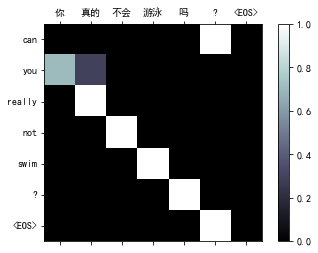

972m 2s (- 890m 6s) (26100 52%) 0.0206
975m 5s (- 885m 46s) (26200 52%) 0.0224
978m 7s (- 881m 25s) (26300 52%) 0.0217
981m 12s (- 877m 8s) (26400 52%) 0.0207
984m 18s (- 872m 52s) (26500 53%) 0.0218
987m 21s (- 868m 34s) (26600 53%) 0.0206
990m 22s (- 864m 15s) (26700 53%) 0.0201
993m 27s (- 860m 0s) (26800 53%) 0.0213
996m 30s (- 855m 44s) (26900 53%) 0.0255
999m 34s (- 851m 29s) (27000 54%) 0.0335
> 我 每天 洗 一次 澡 。
= i take a bath every day .
< i have a bath every day . <EOS>


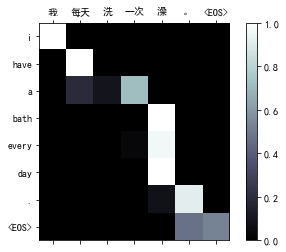

1002m 37s (- 847m 14s) (27100 54%) 0.0268
1005m 42s (- 843m 1s) (27200 54%) 0.0228
1008m 44s (- 838m 46s) (27300 54%) 0.0219
1011m 50s (- 834m 35s) (27400 54%) 0.0219
1014m 53s (- 830m 21s) (27500 55%) 0.0211
1017m 56s (- 826m 9s) (27600 55%) 0.0211
1021m 0s (- 821m 58s) (27700 55%) 0.0209
1024m 5s (- 817m 48s) (27800 55%) 0.0222
1027m 8s (- 813m 36s) (27900 55%) 0.0209
1030m 12s (- 809m 27s) (28000 56%) 0.0214
> 我 怎么 知道 ?
= how should i know ?
< how should i know ? <EOS>


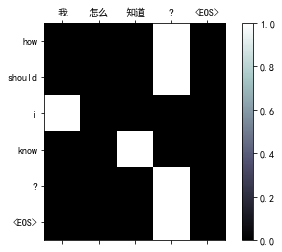

1033m 18s (- 805m 18s) (28100 56%) 0.0217
1036m 23s (- 801m 10s) (28200 56%) 0.0207
1039m 27s (- 797m 2s) (28300 56%) 0.0208
1042m 31s (- 792m 54s) (28400 56%) 0.0201
1045m 36s (- 788m 47s) (28500 56%) 0.0207
1048m 39s (- 784m 39s) (28600 57%) 0.0199
1051m 45s (- 780m 34s) (28700 57%) 0.0220
1054m 46s (- 776m 25s) (28800 57%) 0.0197
1057m 48s (- 772m 18s) (28900 57%) 0.0213
1060m 54s (- 768m 14s) (29000 57%) 0.0207
> 他 是 个 好人 。
= he s a good man .
< he s a good guy . <EOS>


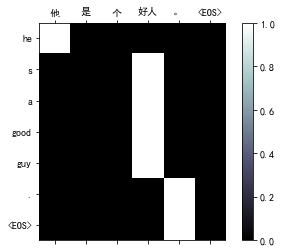

1063m 56s (- 764m 8s) (29100 58%) 0.0209
1066m 59s (- 760m 2s) (29200 58%) 0.0207
1070m 5s (- 755m 59s) (29300 58%) 0.0203
1073m 10s (- 751m 57s) (29400 58%) 0.0211
1076m 17s (- 747m 56s) (29500 59%) 0.0208
1079m 24s (- 743m 54s) (29600 59%) 0.0217
1082m 25s (- 739m 50s) (29700 59%) 0.0211
1085m 30s (- 735m 49s) (29800 59%) 0.0204
1088m 35s (- 731m 47s) (29900 59%) 0.0221
1091m 39s (- 727m 46s) (30000 60%) 0.0211
> 你 想 做 什么 ?
= what do you want to do ?
< what do you want to do ? <EOS>


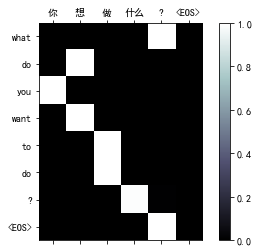

1094m 45s (- 723m 46s) (30100 60%) 0.0205
1097m 51s (- 719m 47s) (30200 60%) 0.0210
1100m 54s (- 715m 46s) (30300 60%) 0.0212
1104m 0s (- 711m 47s) (30400 60%) 0.0206
1107m 2s (- 707m 47s) (30500 61%) 0.0203
1110m 6s (- 703m 47s) (30600 61%) 0.0210
1113m 12s (- 699m 49s) (30700 61%) 0.0213
1116m 14s (- 695m 50s) (30800 61%) 0.0219
1119m 20s (- 691m 53s) (30900 61%) 0.0216
1122m 21s (- 687m 53s) (31000 62%) 0.0213
> 我们 现在 有 了 麻烦 。
= we have a problem here .
< we have a problem here . <EOS>


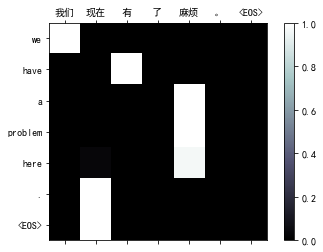

1125m 24s (- 683m 55s) (31100 62%) 0.0199
1128m 27s (- 679m 57s) (31200 62%) 0.0224
1131m 34s (- 676m 3s) (31300 62%) 0.0208
1134m 39s (- 672m 7s) (31400 62%) 0.0216
1137m 44s (- 668m 11s) (31500 63%) 0.0218
1140m 50s (- 664m 17s) (31600 63%) 0.0204
1143m 53s (- 660m 20s) (31700 63%) 0.0220
1146m 55s (- 656m 25s) (31800 63%) 0.0241
1149m 57s (- 652m 28s) (31900 63%) 0.0361
1152m 59s (- 648m 33s) (32000 64%) 0.0260
> 你好 吗 ?
= how are you ?
< how are you ? <EOS>


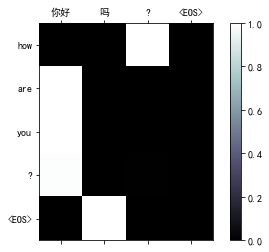

1156m 3s (- 644m 39s) (32100 64%) 0.0245
1159m 9s (- 640m 46s) (32200 64%) 0.0235
1162m 13s (- 636m 52s) (32300 64%) 0.0215
1165m 17s (- 632m 59s) (32400 64%) 0.0206
1168m 19s (- 629m 5s) (32500 65%) 0.0211
1171m 25s (- 625m 14s) (32600 65%) 0.0218
1174m 31s (- 621m 23s) (32700 65%) 0.0212
1177m 37s (- 617m 32s) (32800 65%) 0.0207
1180m 40s (- 613m 40s) (32900 65%) 0.0211
1183m 45s (- 609m 48s) (33000 66%) 0.0212
> 汤姆 不能 原谅 玛丽 。
= tom can t get over mary .
< tom can t get over mary . <EOS>


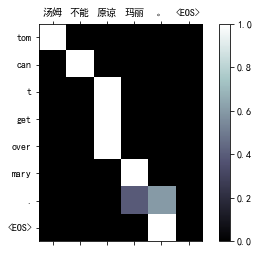

1186m 47s (- 605m 56s) (33100 66%) 0.0212
1189m 51s (- 602m 5s) (33200 66%) 0.0211
1192m 58s (- 598m 16s) (33300 66%) 0.0203
1196m 0s (- 594m 25s) (33400 66%) 0.0214
1199m 7s (- 590m 36s) (33500 67%) 0.0212
1202m 17s (- 586m 49s) (33600 67%) 0.0210
1205m 22s (- 583m 0s) (33700 67%) 0.0211
1208m 29s (- 579m 13s) (33800 67%) 0.0202
1211m 36s (- 575m 25s) (33900 67%) 0.0201
1214m 38s (- 571m 35s) (34000 68%) 0.0203
> 汤姆 不 喜欢 我 。
= tom doesn t like me .
< tom doesn t like me . <EOS>


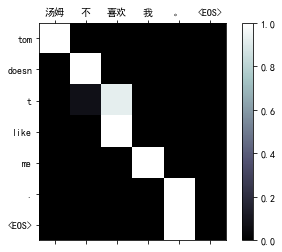

1217m 43s (- 567m 47s) (34100 68%) 0.0197
1220m 46s (- 563m 59s) (34200 68%) 0.0210
1223m 49s (- 560m 10s) (34300 68%) 0.0207
1226m 55s (- 556m 23s) (34400 68%) 0.0205
1230m 0s (- 552m 36s) (34500 69%) 0.0206
1233m 2s (- 548m 48s) (34600 69%) 0.0210
1236m 6s (- 545m 1s) (34700 69%) 0.0205
1239m 9s (- 541m 14s) (34800 69%) 0.0215
1242m 11s (- 537m 27s) (34900 69%) 0.0211
1245m 16s (- 533m 41s) (35000 70%) 0.0211
> 我 希望 我 可以 去 。
= i wish i could go .
< i wish i could go . <EOS>


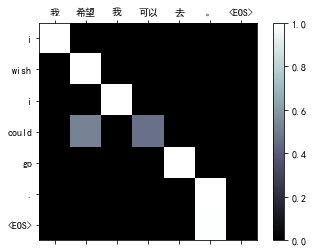

1248m 19s (- 529m 54s) (35100 70%) 0.0207
1251m 24s (- 526m 9s) (35200 70%) 0.0208
1254m 27s (- 522m 23s) (35300 70%) 0.0219
1257m 28s (- 518m 37s) (35400 70%) 0.0215
1260m 29s (- 514m 50s) (35500 71%) 0.0214
1263m 32s (- 511m 5s) (35600 71%) 0.0217
1266m 37s (- 507m 21s) (35700 71%) 0.0210
1269m 44s (- 503m 38s) (35800 71%) 0.0267
1272m 48s (- 499m 54s) (35900 71%) 0.0280
1275m 49s (- 496m 9s) (36000 72%) 0.0249
> 这个 故事 是 真的 。
= this story is true .
< this story is true . <EOS>


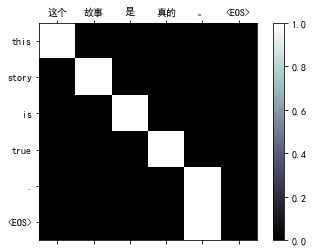

1278m 52s (- 492m 25s) (36100 72%) 0.0214
1281m 55s (- 488m 41s) (36200 72%) 0.0216
1285m 2s (- 484m 59s) (36300 72%) 0.0219
1288m 3s (- 481m 15s) (36400 72%) 0.0212
1291m 7s (- 477m 32s) (36500 73%) 0.0222
1294m 12s (- 473m 50s) (36600 73%) 0.0220
1297m 17s (- 470m 8s) (36700 73%) 0.0208
1300m 19s (- 466m 25s) (36800 73%) 0.0222
1303m 23s (- 462m 43s) (36900 73%) 0.0208
1306m 30s (- 459m 2s) (37000 74%) 0.0212
> 你 应该 去 看 医生 。
= you should see a doctor .
< you should see a doctor . <EOS>


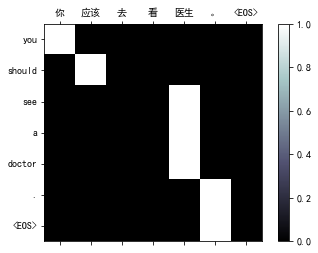

1309m 34s (- 455m 21s) (37100 74%) 0.0214
1312m 38s (- 451m 39s) (37200 74%) 0.0203
1315m 45s (- 447m 59s) (37300 74%) 0.0211
1318m 48s (- 444m 18s) (37400 74%) 0.0211
1321m 54s (- 440m 38s) (37500 75%) 0.0204
1325m 4s (- 436m 59s) (37600 75%) 0.0209
1328m 6s (- 433m 18s) (37700 75%) 0.0201
1331m 12s (- 429m 38s) (37800 75%) 0.0204
1334m 20s (- 426m 0s) (37900 75%) 0.0210
1337m 21s (- 422m 19s) (38000 76%) 0.0202
> 我 自己 做 的 。
= i made it myself .
< i made it myself . <EOS>


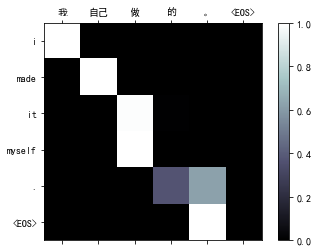

1340m 21s (- 418m 38s) (38100 76%) 0.0209
1343m 27s (- 414m 59s) (38200 76%) 0.0191
1346m 30s (- 411m 20s) (38300 76%) 0.0198
1349m 34s (- 407m 41s) (38400 76%) 0.0194
1352m 59s (- 404m 8s) (38500 77%) 0.0212
1357m 31s (- 400m 55s) (38600 77%) 0.0210
1362m 11s (- 397m 44s) (38700 77%) 0.0205
1366m 47s (- 394m 32s) (38800 77%) 0.0215
1371m 21s (- 391m 18s) (38900 77%) 0.0214
1376m 0s (- 388m 6s) (39000 78%) 0.0202
> 我 开始 跑 。
= i began running .
< i began running . <EOS>


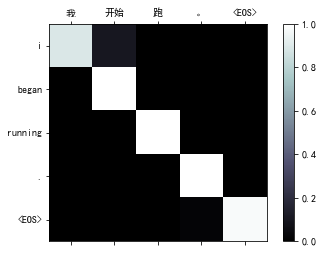

1380m 39s (- 384m 53s) (39100 78%) 0.0207
1385m 16s (- 381m 39s) (39200 78%) 0.0207
1389m 52s (- 378m 24s) (39300 78%) 0.0213
1394m 28s (- 375m 9s) (39400 78%) 0.0195
1399m 7s (- 371m 55s) (39500 79%) 0.0215
1403m 47s (- 368m 40s) (39600 79%) 0.0252
1408m 22s (- 365m 23s) (39700 79%) 0.0251
1412m 55s (- 362m 6s) (39800 79%) 0.0247
1417m 30s (- 358m 48s) (39900 79%) 0.0232
1422m 7s (- 355m 31s) (40000 80%) 0.0207
> 你 想 去 吗 ?
= would you like to go ?
< would you like to go ? <EOS>


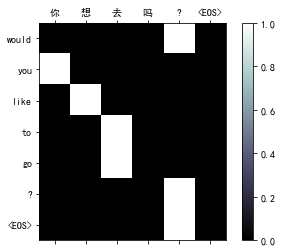

1426m 41s (- 352m 13s) (40100 80%) 0.0215
1431m 14s (- 348m 54s) (40200 80%) 0.0203
1435m 53s (- 345m 36s) (40300 80%) 0.0217
1440m 24s (- 342m 16s) (40400 80%) 0.0217
1444m 53s (- 338m 55s) (40500 81%) 0.0215
1449m 31s (- 335m 36s) (40600 81%) 0.0195
1454m 5s (- 332m 15s) (40700 81%) 0.0221
1458m 44s (- 328m 55s) (40800 81%) 0.0201
1463m 14s (- 325m 33s) (40900 81%) 0.0211
1467m 45s (- 322m 11s) (41000 82%) 0.0214
> 你 是 汤姆 吗 ?
= are you tom ?
< are you tom ? <EOS>


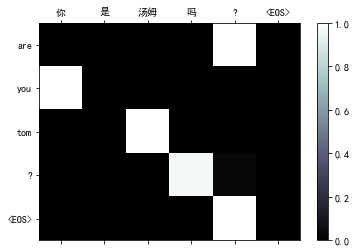

1472m 23s (- 318m 50s) (41100 82%) 0.0208
1476m 58s (- 315m 28s) (41200 82%) 0.0213
1481m 34s (- 312m 5s) (41300 82%) 0.0212
1486m 9s (- 308m 43s) (41400 82%) 0.0218
1490m 48s (- 305m 20s) (41500 83%) 0.0212
1495m 34s (- 301m 59s) (41600 83%) 0.0206
1500m 10s (- 298m 35s) (41700 83%) 0.0209
1504m 44s (- 295m 11s) (41800 83%) 0.0214
1509m 17s (- 291m 46s) (41900 83%) 0.0208
1513m 54s (- 288m 21s) (42000 84%) 0.0218
> 我会 自己 走 。
= i ll go by myself .
< i ll go by myself . <EOS>


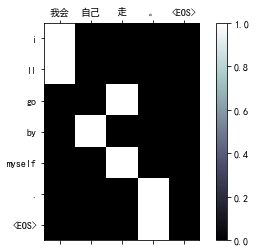

1518m 31s (- 284m 57s) (42100 84%) 0.0218
1523m 7s (- 281m 31s) (42200 84%) 0.0208
1527m 43s (- 278m 5s) (42300 84%) 0.0209
1532m 16s (- 274m 39s) (42400 84%) 0.0214
1536m 50s (- 271m 12s) (42500 85%) 0.0215
1541m 17s (- 267m 44s) (42600 85%) 0.0227
1545m 54s (- 264m 17s) (42700 85%) 0.0255
1550m 29s (- 260m 49s) (42800 85%) 0.0233
1555m 9s (- 257m 22s) (42900 85%) 0.0233
1559m 40s (- 253m 54s) (43000 86%) 0.0224
> 我们 需要 做 计划 。
= we need to make a plan .
< we need to make a plan . <EOS>


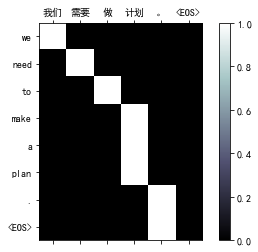

1564m 15s (- 250m 25s) (43100 86%) 0.0219
1568m 50s (- 246m 56s) (43200 86%) 0.0229
1573m 26s (- 243m 27s) (43300 86%) 0.0223
1577m 2s (- 239m 49s) (43400 86%) 0.0222
1580m 6s (- 236m 6s) (43500 87%) 0.0206
1583m 11s (- 232m 23s) (43600 87%) 0.0216
1586m 13s (- 228m 40s) (43700 87%) 0.0215
1589m 19s (- 224m 58s) (43800 87%) 0.0212
1592m 26s (- 221m 16s) (43900 87%) 0.0204
1595m 31s (- 217m 34s) (44000 88%) 0.0216
> 汤姆 让 玛丽 回家 。
= tom let mary go home .
< tom let mary go home . <EOS>


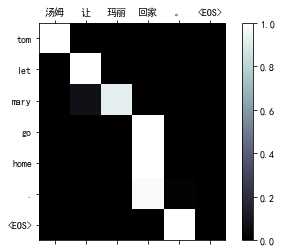

1598m 40s (- 213m 52s) (44100 88%) 0.0212
1602m 29s (- 210m 16s) (44200 88%) 0.0212
1607m 6s (- 206m 46s) (44300 88%) 0.0213
1611m 42s (- 203m 16s) (44400 88%) 0.0219
1616m 21s (- 199m 46s) (44500 89%) 0.0206
1620m 57s (- 196m 15s) (44600 89%) 0.0205
1625m 33s (- 192m 44s) (44700 89%) 0.0208
1630m 8s (- 189m 12s) (44800 89%) 0.0203
1634m 46s (- 185m 41s) (44900 89%) 0.0214
1639m 20s (- 182m 8s) (45000 90%) 0.0200
> 他们 都 喜欢 唱歌 。
= they like to sing .
< they like to sing . <EOS>


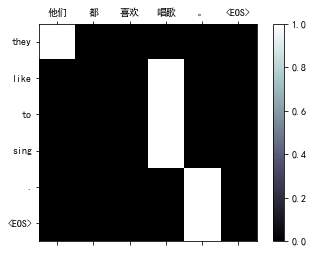

1643m 54s (- 178m 36s) (45100 90%) 0.0202
1648m 32s (- 175m 3s) (45200 90%) 0.0202
1653m 8s (- 171m 31s) (45300 90%) 0.0202
1657m 44s (- 167m 57s) (45400 90%) 0.0208
1662m 17s (- 164m 24s) (45500 91%) 0.0208
1666m 54s (- 160m 50s) (45600 91%) 0.0209
1671m 30s (- 157m 16s) (45700 91%) 0.0215
1676m 5s (- 153m 42s) (45800 91%) 0.0215
1680m 42s (- 150m 7s) (45900 91%) 0.0219
1685m 15s (- 146m 32s) (46000 92%) 0.0196
> 我 在 找 你 。
= i m looking for you .
< i m looking for you . <EOS>


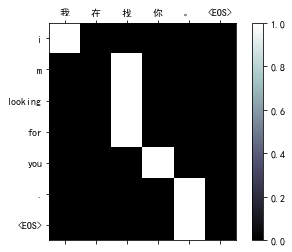

1689m 51s (- 142m 57s) (46100 92%) 0.0201
1694m 26s (- 139m 22s) (46200 92%) 0.0210
1698m 53s (- 135m 45s) (46300 92%) 0.0205
1703m 26s (- 132m 9s) (46400 92%) 0.0213
1708m 0s (- 128m 33s) (46500 93%) 0.0207
1712m 42s (- 124m 57s) (46600 93%) 0.0208
1717m 13s (- 121m 20s) (46700 93%) 0.0221
1720m 19s (- 117m 37s) (46800 93%) 0.0273
1723m 23s (- 113m 54s) (46900 93%) 0.0236
1726m 53s (- 110m 13s) (47000 94%) 0.0215
> 请 进来 。
= please come in .
< please come in . <EOS>


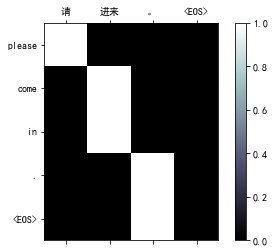

1731m 27s (- 106m 36s) (47100 94%) 0.0231
1736m 3s (- 102m 59s) (47200 94%) 0.0246
1740m 42s (- 99m 21s) (47300 94%) 0.0228
1745m 19s (- 95m 44s) (47400 94%) 0.0209
1749m 51s (- 92m 5s) (47500 95%) 0.0204
1754m 28s (- 88m 27s) (47600 95%) 0.0210
1759m 6s (- 84m 49s) (47700 95%) 0.0214
1763m 40s (- 81m 10s) (47800 95%) 0.0222
1768m 18s (- 77m 31s) (47900 95%) 0.0220
1772m 56s (- 73m 52s) (48000 96%) 0.0218
> 我们 应该 去 哪里 ?
= where should we go ?
< where should we go ? <EOS>


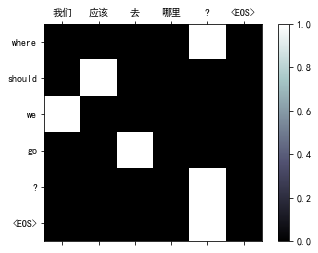

1777m 36s (- 70m 13s) (48100 96%) 0.0213
1782m 14s (- 66m 33s) (48200 96%) 0.0213
1786m 49s (- 62m 53s) (48300 96%) 0.0219
1791m 23s (- 59m 13s) (48400 96%) 0.0217
1796m 0s (- 55m 32s) (48500 97%) 0.0222
1800m 37s (- 51m 52s) (48600 97%) 0.0210
1805m 15s (- 48m 11s) (48700 97%) 0.0218
1809m 50s (- 44m 30s) (48800 97%) 0.0210
1814m 25s (- 40m 48s) (48900 97%) 0.0206
1818m 58s (- 37m 7s) (49000 98%) 0.0208
> 那 一个 真 好 。
= that one is really good .
< that one is really good . <EOS>


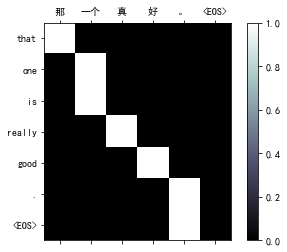

1823m 35s (- 33m 25s) (49100 98%) 0.0222
1828m 10s (- 29m 43s) (49200 98%) 0.0206
1832m 43s (- 26m 1s) (49300 98%) 0.0215
1837m 16s (- 22m 18s) (49400 98%) 0.0214
1841m 52s (- 18m 36s) (49500 99%) 0.0210
1846m 25s (- 14m 53s) (49600 99%) 0.0215
1851m 2s (- 11m 10s) (49700 99%) 0.0217
1855m 39s (- 7m 27s) (49800 99%) 0.0206
1860m 16s (- 3m 43s) (49900 99%) 0.0209
1864m 52s (- 0m 0s) (50000 100%) 0.0211
> 她 不是 小孩 。
= she s not a child .
< she s not a child . <EOS>


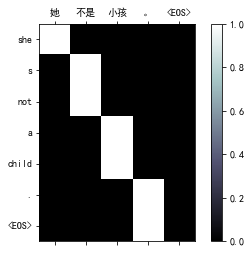

In [33]:
# Begin!
ecs = []
dcs = []
eca = 0
dca = 0

while epoch < n_epochs:
    epoch += 1
    
    # Get training data for this cycle
    input_batches, input_lengths, target_batches, target_lengths = random_batch(batch_size)

    # Run the train function
    loss, ec, dc = train(
        input_batches, input_lengths, target_batches, target_lengths,
        encoder, decoder,
        encoder_optimizer, decoder_optimizer, criterion
    )

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc


    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        
    if epoch % evaluate_every == 0:
        evaluate_randomly()

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
        
        # TODO: Running average helper
        ecs.append(eca / plot_every)
        dcs.append(dca / plot_every)
        ecs_win = 'encoder grad (%s)' % hostname
        dcs_win = 'decoder grad (%s)' % hostname
        vis.line(np.array(ecs), win=ecs_win, opts={'title': ecs_win})
        vis.line(np.array(dcs), win=dcs_win, opts={'title': dcs_win})
        eca = 0
        dca = 0

## 损失绘图

<Figure size 432x288 with 0 Axes>

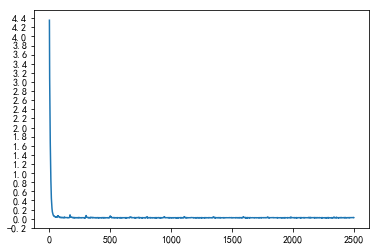

In [34]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

/home/lili/tf1.5-py3/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


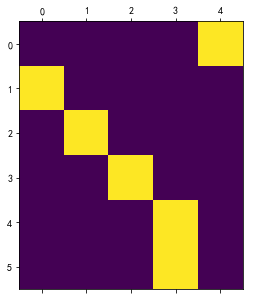

In [35]:
output_words, attentions = evaluate("你 爱 音乐 吗 ？")
plt.matshow(attentions.numpy())
show_plot_visdom()

/home/lili/tf1.5-py3/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


> 你 爱 音乐 吗 ？
< do you love music ? <EOS>


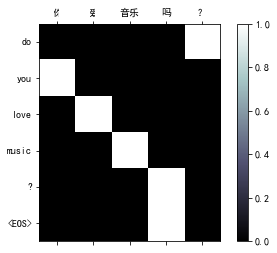

In [36]:
evaluate_and_show_attention("你 爱 音乐 吗 ？")